GEREKLİ KÜTÜPHANELERİN IMPORT EDİLİP , VERİLERİN OKUTULMASI



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

df_power = pd.read_csv("active power (1).csv")
df_temp = pd.read_csv("bearing temp (1).csv")
df_wind = pd.read_csv("wind speed (1).csv")

df_temp.dropna(inplace= True)
df_power.dropna(inplace=True)
df_wind.dropna(inplace=True)
df_temp


,Data Source,Time,Value
0,Temp_Bearing_B,22-Aug-25 00:00:00,42
1,Temp_Bearing_B,22-Aug-25 00:10:00,41
2,Temp_Bearing_B,22-Aug-25 00:20:00,40
3,Temp_Bearing_B,22-Aug-25 00:30:00,40
4,Temp_Bearing_B,22-Aug-25 00:40:00,39
...,...,...,...
4028,Temp_Bearing_B,18-Sep-25 23:20:00,41
4029,Temp_Bearing_B,18-Sep-25 23:30:00,40
4030,Temp_Bearing_B,18-Sep-25 23:40:00,40
4031,Temp_Bearing_B,18-Sep-25 23:50:00,40


In [2]:
df_wind

,Data Source,Time,Value
0,Wind_Speed,8/22/2025 0:00,0
1,Wind_Speed,8/22/2025 0:10,0
2,Wind_Speed,8/22/2025 0:20,0
3,Wind_Speed,8/22/2025 0:30,0
4,Wind_Speed,8/22/2025 0:40,0
...,...,...,...
4028,Wind_Speed,9/18/2025 23:20,8
4029,Wind_Speed,9/18/2025 23:30,9
4030,Wind_Speed,9/18/2025 23:40,7
4031,Wind_Speed,9/18/2025 23:50,8


In [3]:
df_power

,Data Source,Time,Value
0,Active Power Avg,22-Aug-25 00:00:00,-30.79780579
1,Active Power Avg,22-Aug-25 00:10:00,-35.70564651
2,Active Power Avg,22-Aug-25 00:20:00,-28.00777054
3,Active Power Avg,22-Aug-25 00:30:00,-28.71239471
4,Active Power Avg,22-Aug-25 00:40:00,-28.7156601
...,...,...,...
4028,Active Power Avg,18-Sep-25 23:20:00,998.206604
4029,Active Power Avg,18-Sep-25 23:30:00,921.4388428
4030,Active Power Avg,18-Sep-25 23:40:00,577.8806763
4031,Active Power Avg,18-Sep-25 23:50:00,993.0561523


VERİ TEMİZLEME VE DÖNÜŞTÜRME İŞLEMLERİ






In [4]:
# ZAMAN VE SAYI FORMATLARI DÜZENLEME
df_power['Time'] = pd.to_datetime(df_power['Time'], format='%d-%b-%y %H:%M:%S', errors='coerce')
df_temp['Time'] = pd.to_datetime(df_temp['Time'], format='%d-%b-%y %H:%M:%S', errors='coerce')
df_wind['Time'] = pd.to_datetime(df_wind['Time'], format='%m/%d/%Y %H:%M', errors='coerce')

df_power['Value'] = pd.to_numeric(df_power['Value'], errors='coerce')
df_temp['Value'] = pd.to_numeric(df_temp['Value'], errors='coerce')
df_wind['Value'] = pd.to_numeric(df_wind['Value'], errors='coerce')

df_power = df_power[['Time', 'Value']].rename(columns={'Value': 'Active_Power'})
df_temp = df_temp[['Time', 'Value']].rename(columns={'Value': 'Bearing_Temp'})
df_wind = df_wind[['Time', 'Value']].rename(columns={'Value': 'Wind_Speed'})

In [5]:
# VERİ BİRLEŞTİRME
df = pd.merge(df_power, df_wind, on='Time', how='inner')
df = pd.merge(df, df_temp, on='Time', how='inner')

df = df.set_index('Time').sort_index()

# AYKIRI DEĞER TEMİZLİĞİ (-250 gibi saçma değerler vardı onları sildik)
print(f"Temizlik Öncesi Veri Sayısı: {len(df)}")
df = df[df['Bearing_Temp'] > -100]
print(f"Temizlik Sonrası Veri Sayısı: {len(df)}")

# VERİNİN SON HALİNİ KONTROL ETME
print(" Model İçin Hazır Veri Seti:")
print(df.head())
print(df.describe())

Temizlik Öncesi Veri Sayısı: 4033
Temizlik Sonrası Veri Sayısı: 4021
 Model İçin Hazır Veri Seti:
                     Active_Power  Wind_Speed  Bearing_Temp
Time                                                       
2025-08-22 00:00:00    -30.797806         0.0          42.0
2025-08-22 00:10:00    -35.705647         0.0          41.0
2025-08-22 00:20:00    -28.007771         0.0          40.0
2025-08-22 00:30:00    -28.712395         0.0          40.0
2025-08-22 00:40:00    -28.715660         0.0          39.0
       Active_Power   Wind_Speed  Bearing_Temp
count   4021.000000  4021.000000   4021.000000
mean    1558.242827     9.141258     50.116389
std     1078.252244     3.830285     11.163702
min      -46.913746     0.000000     26.000000
25%      437.782471     7.000000     41.000000
50%     1772.703979    10.000000     52.000000
75%     2659.562744    12.000000     59.000000
max     2840.051025    20.000000     70.000000


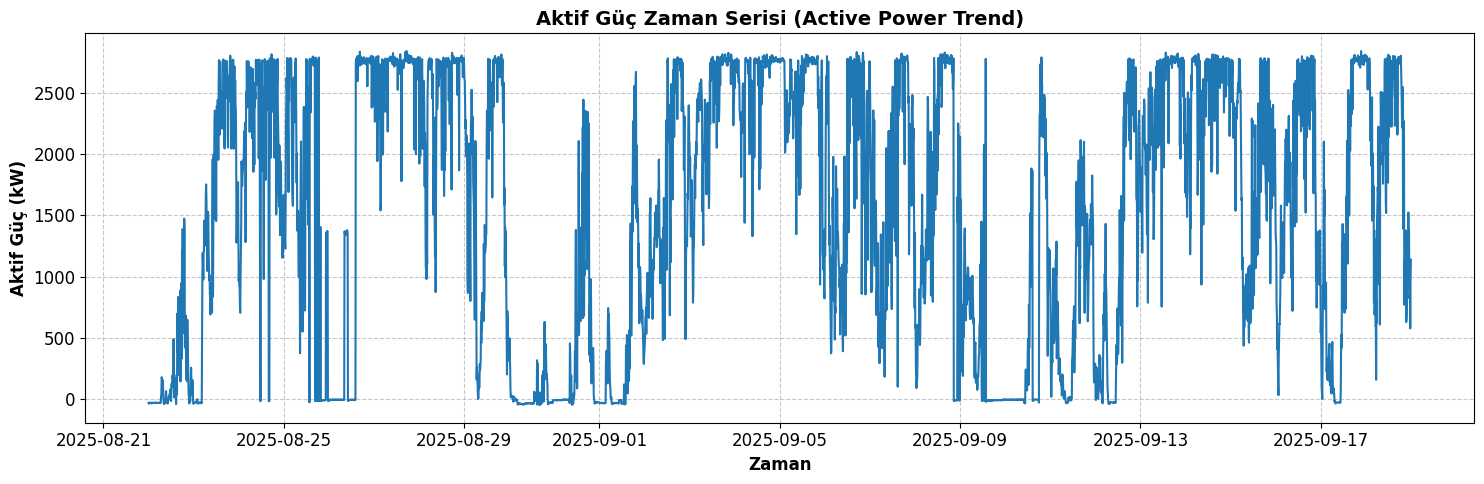

In [6]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x=df.index, y='Active_Power', color='#1f77b4', linewidth=1.5)

plt.title('Aktif Güç Zaman Serisi (Active Power Trend)', fontweight='bold', fontsize=14)
plt.ylabel('Aktif Güç (kW)', fontweight='bold')
plt.xlabel('Zaman', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

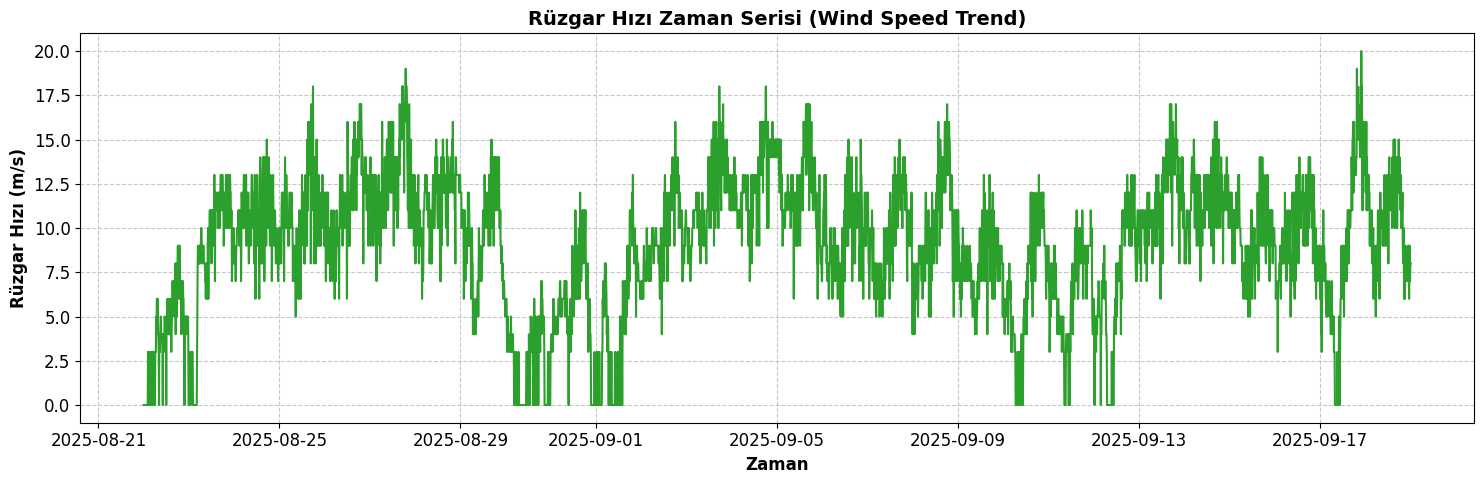

In [7]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x=df.index, y='Wind_Speed', color='#2ca02c', linewidth=1.5)

plt.title('Rüzgar Hızı Zaman Serisi (Wind Speed Trend)', fontweight='bold', fontsize=14)
plt.ylabel('Rüzgar Hızı (m/s)', fontweight='bold')
plt.xlabel('Zaman', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

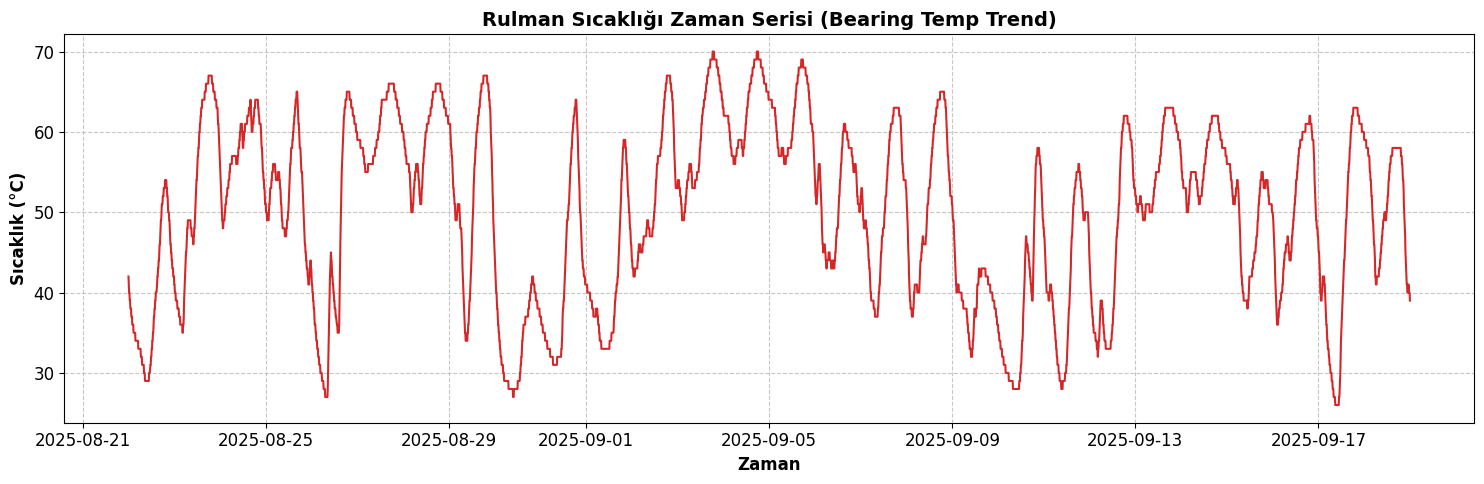

In [8]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x=df.index, y='Bearing_Temp', color='#d62728', linewidth=1.5)

plt.title('Rulman Sıcaklığı Zaman Serisi (Bearing Temp Trend)', fontweight='bold', fontsize=14)
plt.ylabel('Sıcaklık (°C)', fontweight='bold')
plt.xlabel('Zaman', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

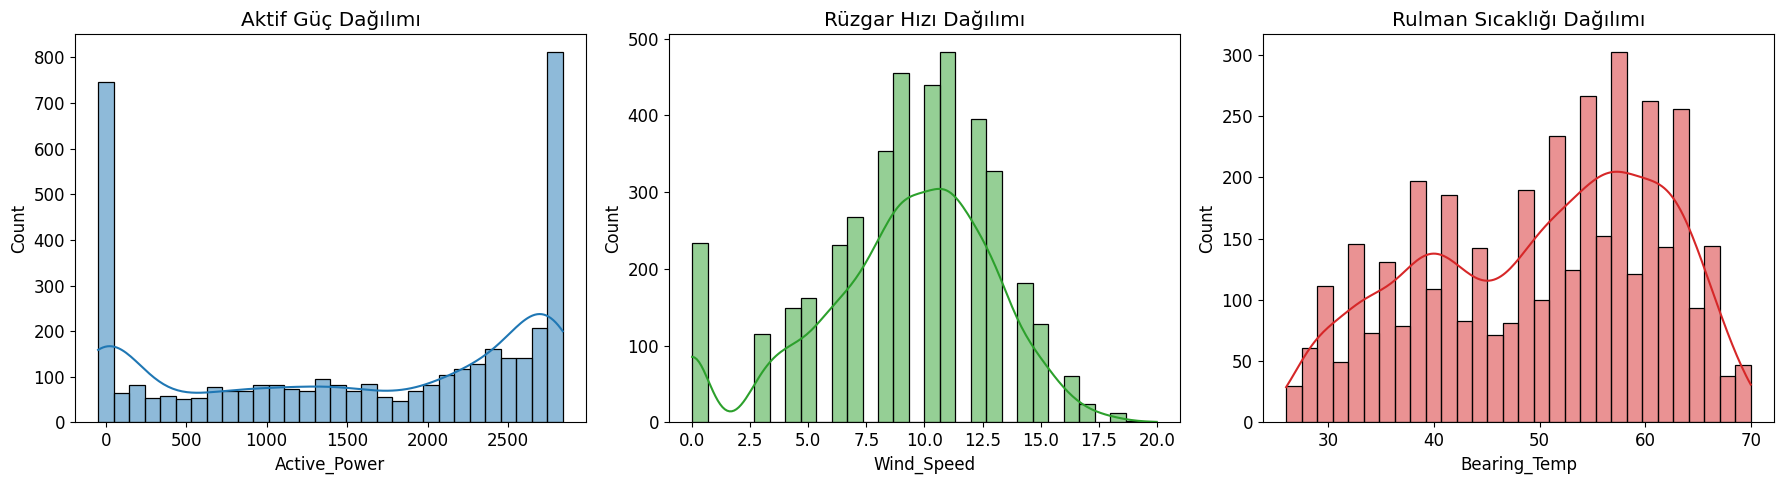

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['Active_Power'], bins=30, kde=True, ax=axes[0], color='#1f77b4')
axes[0].set_title('Aktif Güç Dağılımı')

sns.histplot(df['Wind_Speed'], bins=30, kde=True, ax=axes[1], color='#2ca02c')
axes[1].set_title('Rüzgar Hızı Dağılımı')

sns.histplot(df['Bearing_Temp'], bins=30, kde=True, ax=axes[2], color='#d62728')
axes[2].set_title('Rulman Sıcaklığı Dağılımı')

plt.tight_layout()
plt.show()

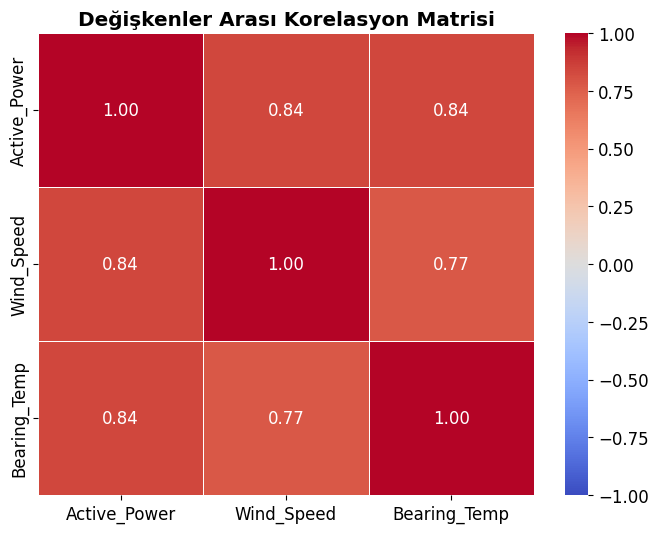

In [10]:
plt.figure(figsize=(8, 6))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Değişkenler Arası Korelasyon Matrisi', fontweight='bold')
plt.show()

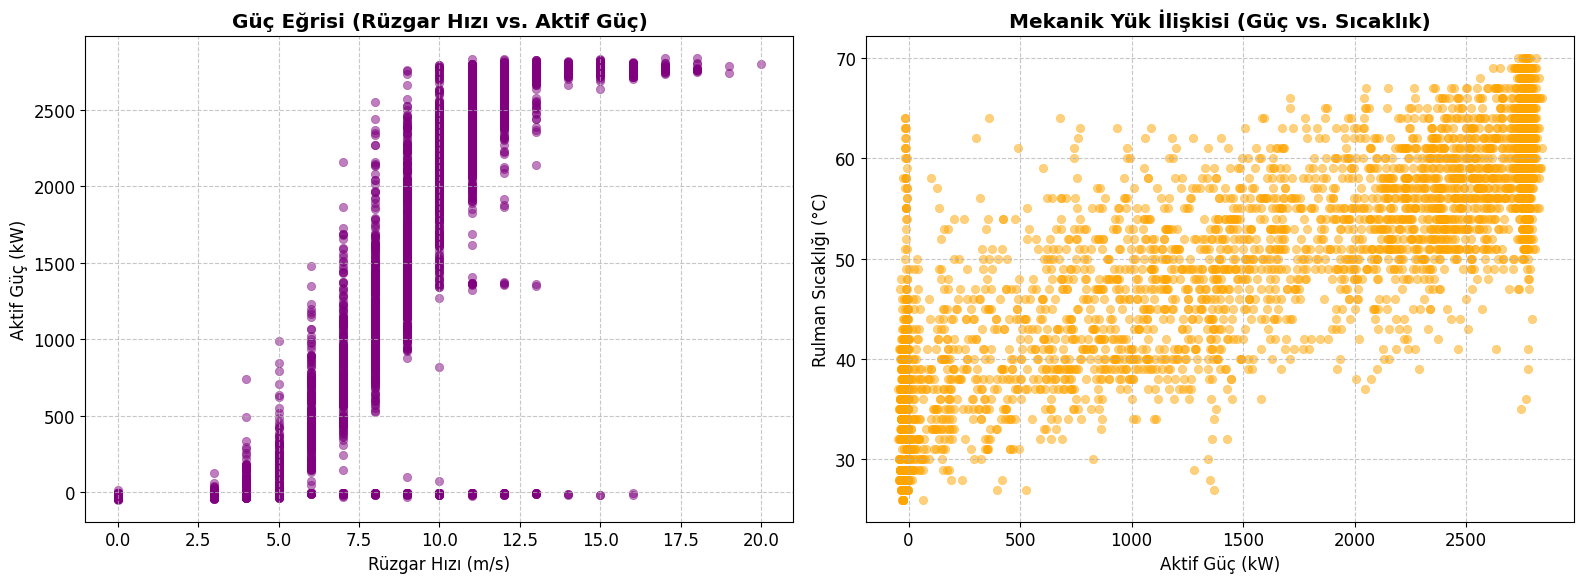

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=df, x='Wind_Speed', y='Active_Power', ax=axes[0], alpha=0.5, color='purple', edgecolor=None)
axes[0].set_title('Güç Eğrisi (Rüzgar Hızı vs. Aktif Güç)', fontweight='bold')
axes[0].set_xlabel('Rüzgar Hızı (m/s)')
axes[0].set_ylabel('Aktif Güç (kW)')
axes[0].grid(True, linestyle='--', alpha=0.7)

sns.scatterplot(data=df, x='Active_Power', y='Bearing_Temp', ax=axes[1], alpha=0.5, color='orange', edgecolor=None)
axes[1].set_title('Mekanik Yük İlişkisi (Güç vs. Sıcaklık)', fontweight='bold')
axes[1].set_xlabel('Aktif Güç (kW)')
axes[1].set_ylabel('Rulman Sıcaklığı (°C)')
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# VERİYİ TRAIN VE TEST OLARAK BÖLME
train_data, test_data = train_test_split(df, test_size=0.20, shuffle=False)

print(f"✅ Toplam Veri Sayısı: {len(df)}")
print(f"📘 Eğitim Verisi (Train): {len(train_data)} satır")
print(f"Yz Test Verisi (Test):    {len(test_data)} satır")

# NORMALİZASYON
scaler = MinMaxScaler()
scaler.fit(train_data)

# TRANSFORM İŞLEMLERİ (VERİLERİ 1 VE 0 ARASINDA SCALE ETTİK)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

#WINDOWING İŞLEMLERİ YAPILDI
def create_sequences(data, steps=6):
    output = []
    for i in range(len(data) - steps + 1):
        output.append(data[i : i + steps])
    return np.array(output)
TIME_STEPS = 6
X_train = create_sequences(train_scaled, TIME_STEPS)
X_test = create_sequences(test_scaled, TIME_STEPS)

print(f"\n✅ MODEL İÇİN HAZIR VERİ BOYUTLARI:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test:  {X_test.shape}")



✅ Toplam Veri Sayısı: 4021
📘 Eğitim Verisi (Train): 3216 satır
Yz Test Verisi (Test):    805 satır

✅ MODEL İÇİN HAZIR VERİ BOYUTLARI:
   X_train: (3211, 6, 3)
   X_test:  (800, 6, 3)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - loss: 0.3453 - val_loss: 0.1628
Epoch 2/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1682 - val_loss: 0.0825
Epoch 3/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1089 - val_loss: 0.0793
Epoch 4/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1015 - val_loss: 0.0700
Epoch 5/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0951 - val_loss: 0.0695
Epoch 6/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0934 - val_loss: 0.0800
Epoch 7/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0924 - val_loss: 0.0692
Epoch 8/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0906 - val_loss: 0.0689
Epoch 9/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0880 - val_loss: 0.0679
Epoch 10/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0888 - val_loss: 0.0633
Epoch 11/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0805 - val_loss: 0.0613
Epoch 12/32
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0839 - val_

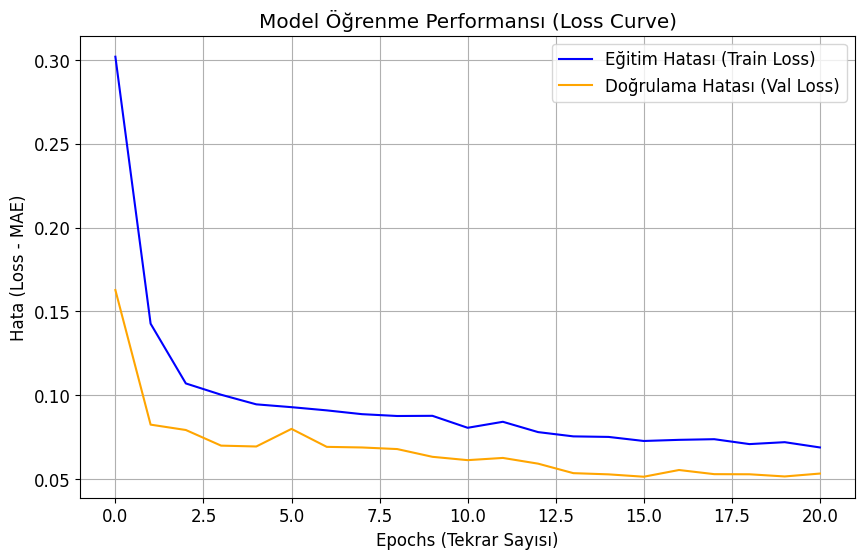

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

model = Sequential([

    # Veriyi alıp işlemeye başlar
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),

    # Veriyi daha da özetler
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),

    # Sıkıştırılmış özeti, Decoder'ın anlayacağı şekilde tekrarla
    RepeatVector(X_train.shape[1]),

    #DECODER
    # Özeti alıp genişletmeye başlar
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),

    # Orijinal boyuta yaklaşır
    LSTM(128, activation='relu', return_sequences=True),
    Dropout(0.2),

    # Her adım için 3 özelliği (Güç, Rüzgar, Sıcaklık) tekrar üretir
    TimeDistributed(Dense(X_train.shape[2]))
])

model.compile(optimizer='adam', loss='mae') # MAE anlık sıçramalara (gürültüye) karşı daha dirençli ve daha kararlı olduğu için kullandım .

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, X_train,
    epochs=32,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Eğitim Hatası (Train Loss)', color='blue')
plt.plot(history.history['val_loss'], label='Doğrulama Hatası (Val Loss)', color='orange')
plt.title('Model Öğrenme Performansı (Loss Curve)')
plt.xlabel('Epochs (Tekrar Sayısı)')
plt.ylabel('Hata (Loss - MAE)')
plt.legend()
plt.grid(True)
plt.show()


101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Belirlenen Anomali Eşiği (Threshold): 0.1698
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
🚨 Yapay Senaryoda Yakalanan Arıza Sayısı: 5


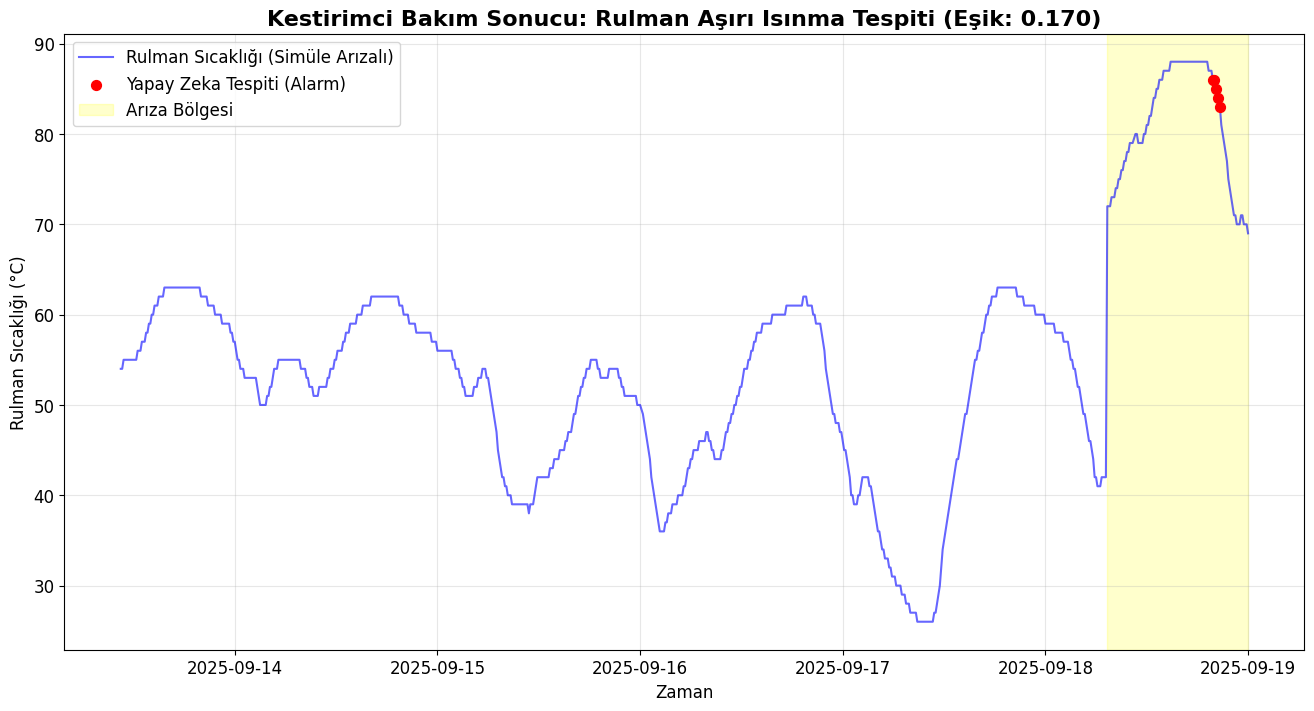

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# THRESHOLD)BELİRLEME
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
train_mae_loss = np.mean(train_mae_loss, axis=1)

THRESHOLD = np.percentile(train_mae_loss, 99)
print(f"Belirlenen Anomali Eşiği (Threshold): {THRESHOLD:.4f}")

# YAPAY ANOMALİ VE İSPAT
test_scaled_injected = test_scaled.copy()
feature_index = 2
drift_start = -100

# Modelimiz çok hassas olduğu için daha belirgin bir arıza verdik.
test_scaled_injected[drift_start:, feature_index] += 0.5

# Modeli bozuk veriyle sınadık
X_test_injected = create_sequences(test_scaled_injected, TIME_STEPS)
X_test_pred = model.predict(X_test_injected)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test_injected), axis=1)
test_mae_loss = np.mean(test_mae_loss, axis=1)

injected_score_df = pd.DataFrame(index=test_data[TIME_STEPS-1:].index)
injected_score_df['loss'] = test_mae_loss
injected_score_df['threshold'] = THRESHOLD
injected_score_df['anomaly'] = injected_score_df['loss'] > injected_score_df['threshold']

# Gerçek Sıcaklık gibi görünmesi için orijinal veriye manuel +30 ekledik
injected_score_df['Bearing_Temp'] = test_data[TIME_STEPS-1:]['Bearing_Temp'].copy()
injected_score_df.loc[injected_score_df.index[drift_start:], 'Bearing_Temp'] += 30

# Yakalanan anomalileri filtrele
anomalies = injected_score_df[injected_score_df['anomaly'] == True]
print(f"🚨 Yapay Senaryoda Yakalanan Arıza Sayısı: {len(anomalies)}")

plt.figure(figsize=(16, 8))
plt.plot(injected_score_df.index, injected_score_df['Bearing_Temp'], label='Rulman Sıcaklığı (Simüle Arızalı)', color='blue', alpha=0.6)
plt.scatter(anomalies.index, anomalies['Bearing_Temp'], color='red', label='Yapay Zeka Tespiti (Alarm)', s=50, zorder=5)
plt.axvspan(injected_score_df.index[drift_start], injected_score_df.index[-1], color='yellow', alpha=0.2, label='Arıza Bölgesi')

plt.title(f'Kestirimci Bakım Sonucu: Rulman Aşırı Isınma Tespiti (Eşik: {THRESHOLD:.3f})', fontsize=16, fontweight='bold')
plt.xlabel('Zaman')
plt.ylabel('Rulman Sıcaklığı (°C)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.show()